In [1]:
import pandas as pd
import numpy as np
import os
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.metrics import r2_score
import walnut_utils as wnut
from importlib import reload

In [2]:
iniN = 3
endN = 52
perbasis = 'accession'

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

filename = src + 'qual_quant_' + perbasis + '_summary.csv'
df = pd.read_csv(filename, dtype={1:str})

df = df.drop(index = df[df['PercentKernel'] == -1].index)
df['TipShrivel'] /= 100
df['MinorShrivel'] /= 100
df['MajorShrivel'] /= 100
df['PercentKernel'] /= 100

print(df.shape)

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]

marker = ['o', 'v','*','^', 's', '<', 'X', '>', 'p', '8', 'h', 'H', 'D', 'd', 'P']
#col_wong = ['#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
col_wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40', '#56e495']
col_wong += col_wong

(149, 67)
(67, 2)


In [3]:
df.head()

,UCACCSD,nut_count,plot_count,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,TipShrivel,MinorShrivel,MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,Blank
0,03-001-3395,6,4,41.382216,34.552443,34.683614,23138.271108,5.061907,1.205837,6740.977257,...,1.075000,5.000000,4.750000,0.000000,0.000000,0.0,4.750000,4.500000,0.623294,0.000000
1,04-004-626,9,1,41.655988,36.264753,33.735949,24456.070925,4.624070,1.234757,6783.986184,...,1.100000,5.000000,6.000000,0.000000,0.000000,0.0,4.000000,5.000000,0.583988,0.000000
2,06-004-4,16,7,37.071349,34.994222,32.470430,20701.067413,4.320171,1.151675,5927.755393,...,1.114286,5.000000,5.000000,0.000000,0.031746,0.0,3.857143,4.857143,0.589313,5.714286
3,06-005-27,15,4,40.523602,33.250514,31.082693,19961.358383,4.605803,1.304487,5915.986251,...,1.475000,5.750000,5.250000,0.000000,0.000000,0.0,3.500000,5.750000,0.482632,2.500000
4,06-030-18,5,3,37.920928,32.983651,31.577548,18617.977820,4.443319,1.201473,5582.720320,...,1.233333,5.666667,5.666667,0.033333,0.000000,0.0,5.000000,5.666667,0.461030,0.000000


In [4]:
himalaya = '85-023-2'
interest = df[df.UCACCSD == himalaya]
other = df[df.UCACCSD != himalaya]

In [5]:
for i in range(len(df.columns)):
    print(i,df.columns[i], labels.col_labels[i], labels.col_units[i], sep='\t')

0	UCACCSD	UCACCSD	
1	nut_count	Batch Name	
2	plot_count	Scan Name	
3	nut_length	Nut Length	 [mm]
4	nut_height	Nut Height	 [mm]
5	nut_width	Nut Width	 [mm]
6	nut_vol	Nut Volume	 [mm$^3$]
7	nut_va3d	Nut VA3D	
8	nut_ratio_feret	Nut Feret Ratio	
9	nut_area	Nut Surface Area	 [mm$^2$]
10	nut_sphericity	Nut Sphericity	
11	nut_cnvx_area	Nut Convex Surface Area	 [mm$^2$]
12	nut_cnvx_vol	Nut Convex Volume	 [mm$^3$]
13	nut_ratio_cnvx_area	Nut Ratio Convex Area	 [%]
14	nut_inv_ratio_cnvx_vol	Nut Ratio Convex Volume	 [%]
15	krumbein	Krumbein Index	
16	sneed	Sneed Index	
17	air_vol	Air Volume	 [mm$^3$]
18	meat_vol	Kernel Volume	 [mm$^3$]
19	shell_vol	Shell Volume	 [mm$^3$]
20	vein_vol	Packing Volume	 [mm$^3$]
21	air_ratio_vol	Air Vol Ratio	 [%]
22	meat_ratio_vol	Kernel Vol Ratio	 [%]
23	shell_ratio_vol	Shell Vol Ratio	 [%]
24	vein_ratio_vol	Packing Vol Ratio	 [%]
25	shell_rugosity	Shell Rugosity	
26	shell_thickness	Shell Thickness	 [mm]
27	shell_prot_ratio	Protruding Shell Ratio	 [%]
28	shell_prot_v

In [6]:
feats = df.iloc[:, iniN:].values.copy()
scorrstat = np.ones((feats.shape[1], feats.shape[1]))
spvalcorr = np.zeros_like(scorrstat)

for i in range(scorrstat.shape[0]-1):
    for j in range(i, scorrstat.shape[1]):
        foo = stats.spearmanr(feats[:,i], feats[:,j])
        
        scorrstat[i,j] = foo.statistic
        spvalcorr[i,j] = foo.pvalue
        
        scorrstat[j,i] = foo.statistic
        spvalcorr[j,i] = foo.pvalue

In [41]:
qtraits = np.arange(endN, len(df.columns))
ptraits = np.arange(iniN,endN)

corr = scorrstat[:endN-iniN, endN-iniN:]
print(corr.shape)

(49, 15)


../hpcc/results/trad/qual_vs_quant_correlation_coeff_v_per_accession


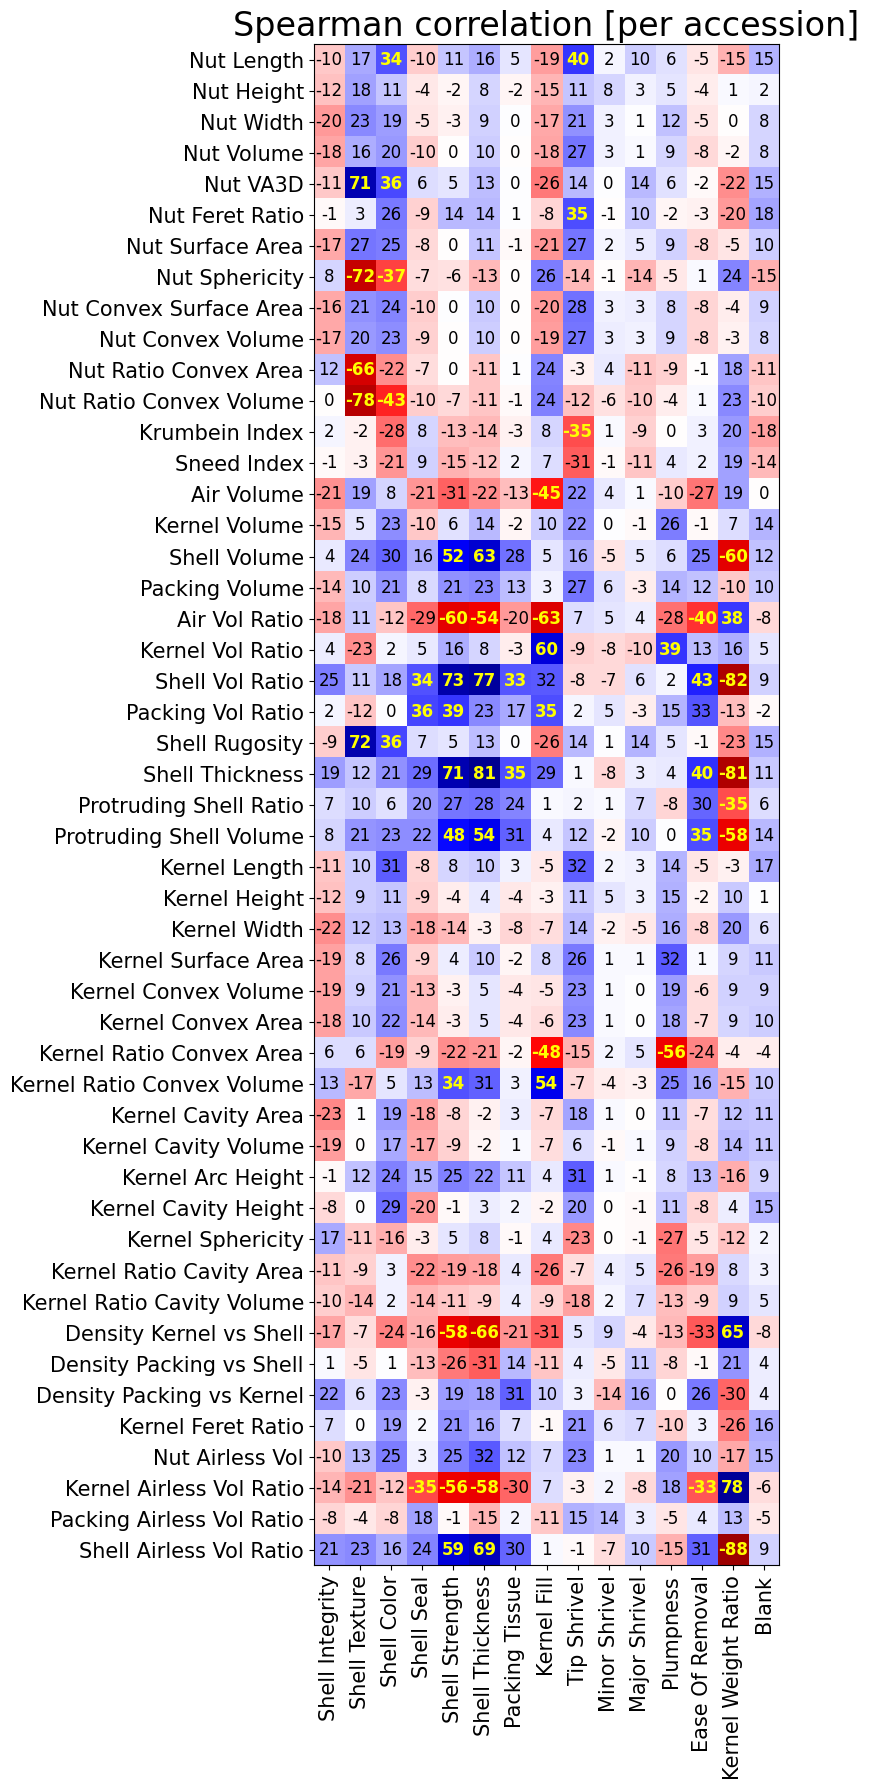

In [43]:
fig, ax = plt.subplots(figsize=(18,18))
im = ax.imshow(corr, cmap='seismic_r', vmin=-1, vmax=1)

# We want to show all ticks...
ax.set_xticks(np.arange(corr.shape[1]))
ax.set_yticks(np.arange(corr.shape[0]))
              
# ... and label them with the respective list entries
ax.set_yticklabels(labels.col_labels.iloc[ptraits])
ax.set_xticklabels(labels.col_labels.iloc[qtraits])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va ='center',
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax.text(j, i, '{:d}'.format(int(np.round(100*corr[i,j]))),
                       ha="center", va="center", color=tcolor, fontsize=12, fontweight=fw)

ax.set_title("Spearman correlation [per "+perbasis+"]", fontsize=24)
#fig.colorbar(im, ax=ax, pad=0.01, shrink=0.5)
fig.tight_layout()

filename = dst + 'qual_vs_quant_correlation_coeff_v_per_' + perbasis
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

../hpcc/results/trad/qual_vs_quant_correlation_coefficients_h_per_accession


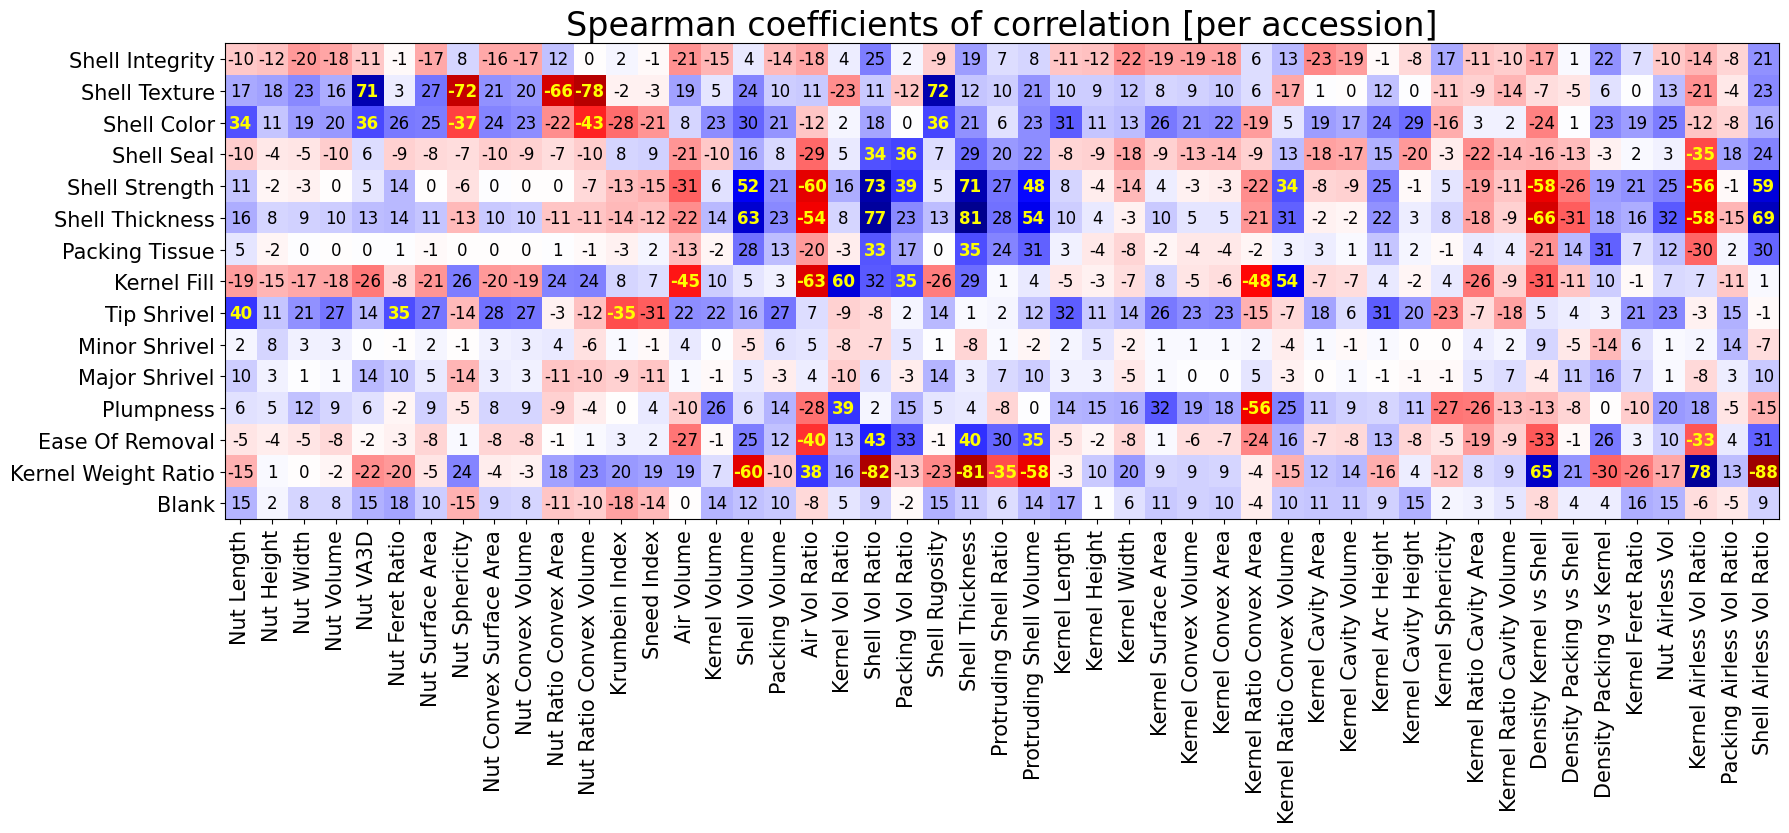

In [46]:
fig, ax = plt.subplots(figsize=(18,18))
im = ax.imshow(corr.T, cmap='seismic_r', vmin=-1, vmax=1)

# We want to show all ticks...
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticks(np.arange(corr.shape[0]))
              
# ... and label them with the respective list entries
ax.set_xticklabels(labels.col_labels.iloc[ptraits])
ax.set_yticklabels(labels.col_labels.iloc[qtraits])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va ='center',
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax.text(i,j, '{:d}'.format(int(np.round(100*corr[i,j]))),
                       ha="center", va="center", color=tcolor, fontsize=12, fontweight=fw)

ax.set_title("Spearman coefficients of correlation [per "+perbasis+"]", fontsize=24)
#fig.colorbar(im, ax=ax, pad=0.01, shrink=0.5)
fig.tight_layout()

filename = dst + 'qual_vs_quant_correlation_coefficients_h_per_' + perbasis
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

# Limited Correlation

In [47]:
if False:
    qtraits = np.array([21,22,23,24] + [49,51,50] + [65])
    ptraits = qtraits.copy()
    filename = src + 'vol_ratios_spearman_correlation_pvals_'+perbasis+'.csv' 

    if os.path.isfile(filename):

        foo = np.loadtxt(filename, delimiter=',')
        scorrstat = foo[:len(qtraits)]
        spvalcorr = foo[len(qtraits):]

    else:
        import resampling

        scorrstat = np.ones((len(qtraits), len(ptraits)))
        spvalcorr = np.zeros_like(scorrstat)

        feats = df.iloc[:, offset:].values.copy()

        for i in range(len(qtraits)):
            for j in range(i):
                x = feats[:,qtraits[i] - offset]
                y = feats[:,ptraits[j] - offset]
                if len(y) < 500:
                    def statistic(x):  # permute only `x`
                        return stats.spearmanr(x, y).correlation
                    sstat, spval = stats.spearmanr(x,y)

                    spval = resampling.permutation_test((x,), statistic, permutation_type='pairings')

                    scorrstat[i,j] = sstat
                    spvalcorr[i,j] = spval.pvalue

        np.savetxt(filename, np.vstack((scorrstat, spvalcorr)), delimiter=',')

In [48]:
qtraits = np.array(list(range(17,25)) + [49,51,50,48] + [26,6,14,44] + [64,56,65,53]) - iniN
corr = scorrstat[qtraits,:][:, qtraits].copy()
pval = spvalcorr[qtraits,:][:, qtraits].copy()    

for i in range(corr.shape[0]-1):
    for j in range(i+1,corr.shape[1]):
        corr[i,j] = 0
        pval[i,j] = 1

In [49]:
pval_ = np.zeros_like(pval).astype(int)
for i in range(pval.shape[0]):
    for j in range(pval.shape[1]):
        if (pval[i,j] > 1e-2):
            pval_[i,j] = 0
        elif (pval[i,j] <= 1e-2) and (pval[i,j] > 1e-3):
            pval_[i,j] = 1
        elif (pval[i,j] <= 1e-3) and (pval[i,j] > 1e-4):
            pval_[i,j] = 2
        else:
            pval_[i,j] = 3
    pval_[i,i] = 0
pval_

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 3, 1, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 2, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 3, 2, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 3, 1, 0, 0, 0, 0, 0,

../hpcc/results/trad/vol_absolute_relative_thick_correlation_accession


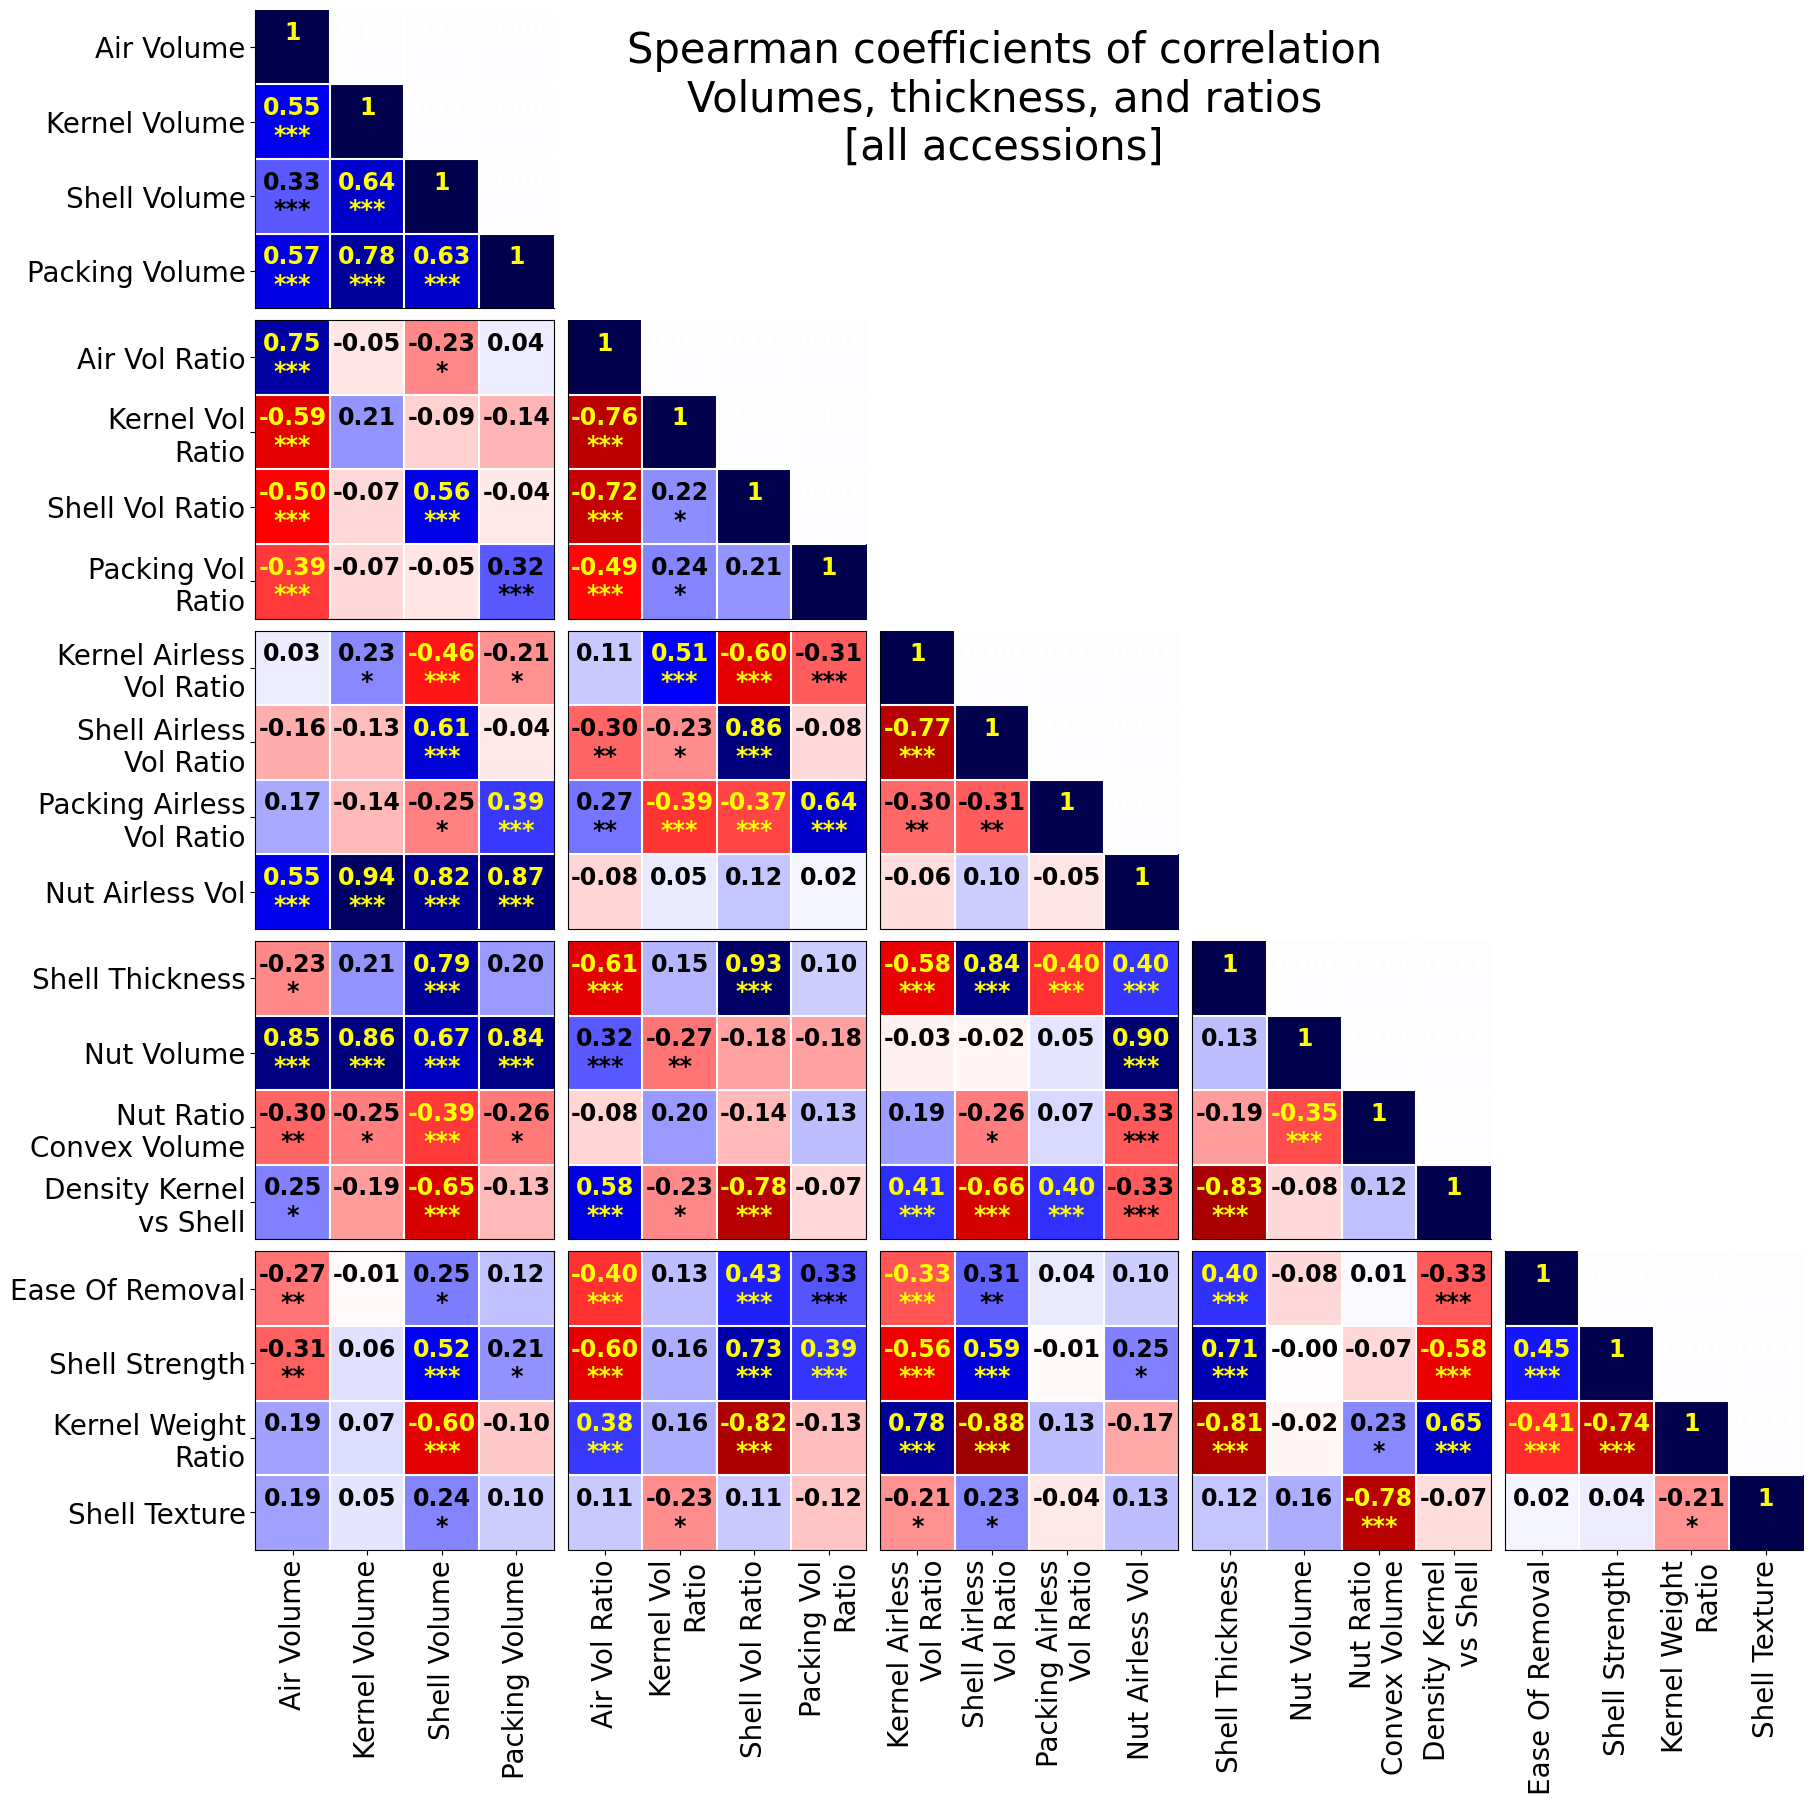

In [52]:
K = 5
fs = 20
tw = 15
pt = 0.
fw = 'bold'
sig = ['', '*', '**', '***']
fig, ax = plt.subplots(K,K,figsize=(20,20))
ax = np.atleast_1d(ax).ravel()

ss = [np.s_[0:4, 0:4], None, None, None, None,
      np.s_[4:8, 0:4], np.s_[4:8, 4:8], None, None, None,
      np.s_[8:12,0:4], np.s_[8:12, 4:8], np.s_[8:12, 8:12], None, None,
      np.s_[12:16,0:4], np.s_[12:16, 4:8], np.s_[12:16,8:12], np.s_[12:16,12:16], None,
      np.s_[16:,:4], np.s_[16:, 4:8], np.s_[16:,8:12], np.s_[16:,12:16], np.s_[16:,16:]
     ]

for i in range(len(ax)):
    if ss[i] is not None:
        aux = corr[ss[i]]
        ax[i].imshow(aux, cmap='seismic_r', vmin=-1, vmax=1)
        for j in range(aux.shape[0]):
            for k in range(aux.shape[1]):
                if np.abs(aux[j,k]) > 0.33:
                    tcolor = 'yellow'
                elif aux[j,k] == 0:
                    tcolor= 'white'
                else:
                    tcolor = 'black'
                
                txt = '{:.2f}\n{}'.format((np.round(aux[j,k],2)), sig[pval_[ss[i]][j,k]])
                if aux[j,k] > 0.99:
                    txt = '1\n{}'.format(sig[pval_[ss[i]][j,k]])
                ax[i].text(k,j, txt,
                            ha="center", va="center", color=tcolor, fontsize=fs-3, fontweight=fw)

        for j in range(3):
            ax[i].axvline(j+.5, color='w')
            ax[i].axhline(j+.5, color='w')
        ax[i].tick_params(labelsize=fs)

    
for i in range(5):
    ax[K*(K-1)+i].set_xticks(range(4), 
                       [textwrap.fill(t,tw) for t in labels.col_labels.iloc[qtraits[ss[K*(K-1)+i][1]]+iniN]],
                       rotation=90, ha='right', va='center', rotation_mode='anchor')
    ax[K*i].set_yticks(range(4),
                       [textwrap.fill(t,tw) for t in labels.col_labels.iloc[qtraits[ss[K*i][0]]+iniN]])

for i in range(K*K-K):
    ax[i].set_xticks([])
for i in range(K):
    for j in range(1,K):
        ax[i*K+j].set_yticks([])

for i in range(K):
    ax[i*K+i].spines['top'].set_visible(False)
    ax[i*K+i].spines['right'].set_visible(False)
    
for i in [1,2,3,4,7,8,9,13,14,19]:
    fig.delaxes(ax[i])
    
fig.suptitle("Spearman coefficients of correlation\nVolumes, thickness, and ratios\n[all "+perbasis+"s]", fontsize=fs+10, y=.87)

plt.subplots_adjust(wspace=0.04, hspace=0.04)

filename = dst + 'vol_absolute_relative_thick_correlation_' +perbasis
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

# Linear models

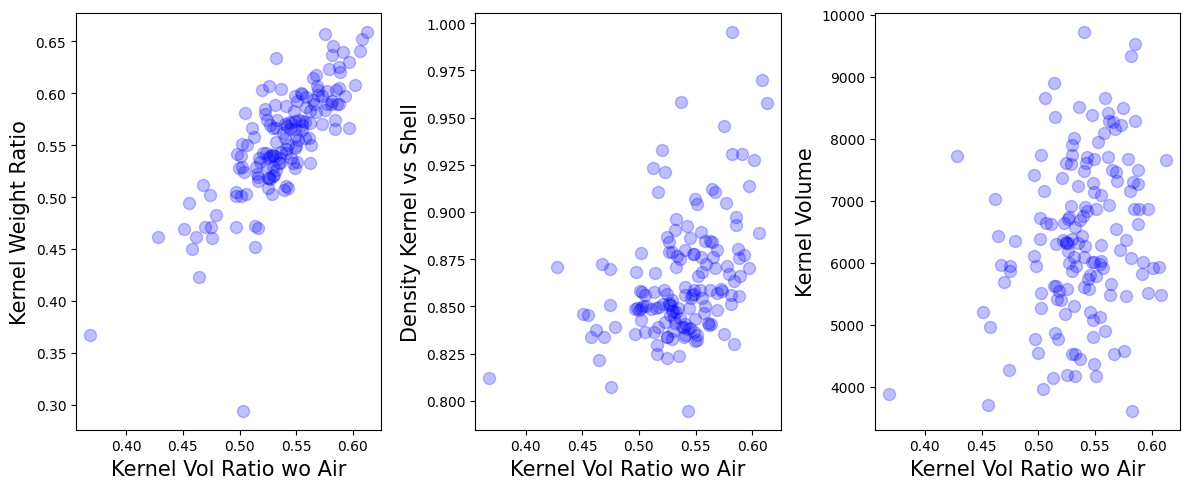

In [31]:
fs = 15
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax = np.atleast_1d(ax).ravel(); i = 0
xidx = 49
yidx = 65
x = (df.iloc[:, xidx].values)

for i,yidx in enumerate([65,44,18]):
    y = (df.iloc[:, yidx].values)

    ax[i].scatter(x,y, c='b', alpha=0.25, s=75)
    #ax[i].plot(y,y, c='r')
    #ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(labelsize=fs-5)

    ax[i].set_xlabel(labels.col_labels[xidx], fontsize=fs);
    ax[i].set_ylabel(labels.col_labels[yidx], fontsize=fs);
    
fig.tight_layout();

# Z-scores

In [37]:
from sklearn import preprocessing as prep

ids = df['UCACCSD'][~df['UCACCSD'].isna()].sort_values().unique()
print(len(ids))
X = prep.StandardScaler().fit_transform(df.iloc[:, iniN:endN].values.copy())

149


NameError: name 'summeans' is not defined

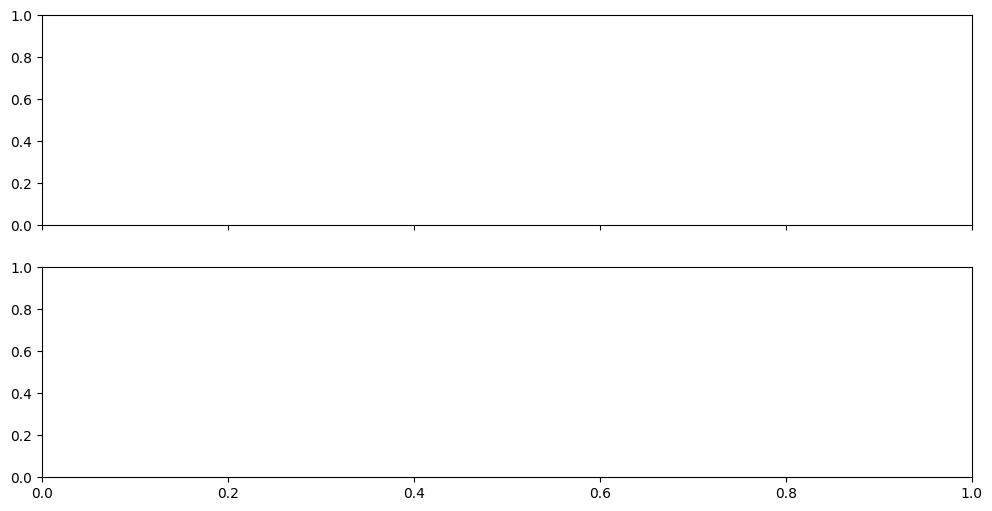

In [38]:
fs = 15
ylabel = ['Mean of Absolute Value', 'Standard Deviation']

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i=0
wid = 141
for i in range(len(ax)):
    arg = np.argsort(summeans[:,i])
    rnk = np.argsort(arg)

    ax[i].bar(range(len(summeans)), summeans[arg,i], color='lightblue', zorder=1);
    ax[i].bar(rnk[easywid], summeans[easywid,i], color='blue', zorder=2)
    ax[i].bar(rnk[earwid], summeans[earwid,i], color='red', zorder=3)
    ax[i].bar(rnk[hardwid], summeans[hardwid,i], color='orange', zorder=2)
    ax[i].set_ylabel(ylabel[i], fontsize=fs)
    ax[i].tick_params(labelsize=fs-3)
    ax[i].text(rnk[wid], summeans[wid,i]+.3, '{}\n{}/{}'.format(ids[wid], rnk[wid]+1,len(summeans)),
                       ha="center", va="center", color='red', fontsize=fs, fontweight='bold')

ax[0].set_yticks(np.linspace(0,1.5,4))
ax[0].set_xticks([])
ax[-1].set_xlabel('Accession rank sorted', fontsize=fs)
ax[0].margins(x=0)
fig.suptitle('Z-scores for all accessions and traits', fontsize=fs+3)
fig.tight_layout();

filename = dst + 'overall_distribution_' + ids[wid] + '_vs_rest'
print(filename)
#plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

# Regression

In [ ]:
fixtrait = 27
mask = list(range(2,fixtrait)) + list(range(fixtrait,51))
X = df.iloc[:,mask].values
print(X.shape)
y = df.iloc[:,fixtrait].values
print(y.shape)

In [ ]:
alphas = np.sort(np.hstack((10**np.linspace(-4,0,5), 5*10**np.linspace(-4,-1,4))))
clf = linear.RidgeCV(alphas=alphas).fit(X,y)
clf.score(X,y)

In [ ]:
clf.alpha_

In [10]:
fs = 22
for yidx in ptraits:
    fig, ax = plt.subplots(2,4,figsize=(20,9), sharey=True)
    ax = np.atleast_1d(ax).ravel()

    y = df.iloc[:, yidx].values

    ax[0].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);
    ax[4].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);

    for i,xidx in enumerate(np.argsort(np.abs(corr[:, yidx-len(qtraits)-offset]))[::-1][:len(ax)] + offset):
        x = df.iloc[:, xidx].values

        xrange = np.linspace(np.min(x)-0.1, np.max(x)+0.1, 100)

        s = corr[xidx - offset, yidx - len(qtraits) - offset]
        ax[i].scatter(x,y, c='b', alpha=0.25, s=75)
        #ax[i].set_aspect('equal', 'datalim')
        ax[i].tick_params(labelsize=fs-2)

        ax[i].set_xlabel(labels.col_labels[xidx] + labels.col_units[xidx], fontsize=fs);

        new_series = P.Polynomial.fit(x,y, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(y, new_series(x))
        axlabel = 'R$^2$ = {:.2}\ns   = {:.2}'.format(r2,s)
        ax[i].plot(xrange, new_series(xrange), color='r', label=axlabel, ls='-.', lw=3)
        #ax.plot(xrange, xrange, color='k', label=axlabel, ls='-.', lw=3)

        ax[i].legend(loc='lower right', fontsize=fs)
    
    fig.suptitle(labels.col_labels[yidx] + ' [averaged by '+perbasis+']', fontsize=fs+3)
    fig.tight_layout()
    filename = dst + 'highest_corrs_' + labels.col_labels[yidx].replace(' ', '_').lower() + '_per_'+perbasis+'_2x4'
    print(filename)
    
    plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

../hpcc/results/trad/highest_corrs_shell_integrity_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_texture_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_color_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_seal_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_strength_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_thickness_per_tree_2x4
../hpcc/results/trad/highest_corrs_packing_tissue_per_tree_2x4
../hpcc/results/trad/highest_corrs_kernel_fill_per_tree_2x4
../hpcc/results/trad/highest_corrs_tip_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_minor_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_major_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_plumpness_per_tree_2x4
../hpcc/results/trad/highest_corrs_ease_of_removal_per_tree_2x4
../hpcc/results/trad/highest_corrs_kernel_weight_ratio_per_tree_2x4
../hpcc/results/trad/highest_corrs_blank_per_tree_2x4


In [11]:
fs = 19
for yidx in ptraits:
    fig, ax = plt.subplots(1,5,figsize=(20,5), sharey=True)
    ax = np.atleast_1d(ax).ravel()
    y = df.iloc[:, yidx].values

    ax[0].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs+4);
    #ax[4].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);

    for i,xidx in enumerate(np.argsort(np.abs(corr[:, yidx-len(qtraits)-offset]))[::-1][:len(ax)] + offset):
        x = df.iloc[:, xidx].values

        xrange = np.linspace(np.min(x)-0.1, np.max(x)+0.1, 100)

        s = corr[xidx - offset, yidx - len(qtraits) - offset]
        ax[i].scatter(x,y, c='b', alpha=0.25, s=75)
        ax[i].tick_params(labelsize=fs-2)

        ax[i].set_xlabel(labels.col_labels[xidx] + labels.col_units[xidx], fontsize=fs);

        new_series = P.Polynomial.fit(x,y, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(y, new_series(x))
        axlabel = 'R$^2$ = {:.2}\ns   = {:.2}'.format(r2,s)
        ax[i].plot(xrange, new_series(xrange), color='r', label=axlabel, ls='-.', lw=3)
        ax[i].legend(loc='lower right', fontsize=fs)
    
    fig.suptitle(labels.col_labels[yidx] + ' [averaged by '+perbasis+']', fontsize=fs+3)
    fig.tight_layout()
    filename = dst + 'highest_corrs_' + labels.col_labels[yidx].replace(' ', '_').lower() + '_per_'+perbasis+'_1x5'
    print(filename)
    
    plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

../hpcc/results/trad/highest_corrs_shell_integrity_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_texture_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_color_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_seal_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_strength_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_thickness_per_tree_1x5
../hpcc/results/trad/highest_corrs_packing_tissue_per_tree_1x5
../hpcc/results/trad/highest_corrs_kernel_fill_per_tree_1x5
../hpcc/results/trad/highest_corrs_tip_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_minor_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_major_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_plumpness_per_tree_1x5
../hpcc/results/trad/highest_corrs_ease_of_removal_per_tree_1x5
../hpcc/results/trad/highest_corrs_kernel_weight_ratio_per_tree_1x5
../hpcc/results/trad/highest_corrs_blank_per_tree_1x5
